<a href="https://colab.research.google.com/github/Delson182/EletivaII/blob/main/An%C3%A1lise_Financeira_e_Previs%C3%A3o_de_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===== SISTEMA DE PREVISÃO DE PREÇOS =====

    Modelos: LSTM, SimpleRNN e GRU
    Ativos: AAPL (Apple) e BTC-USD (Bitcoin)
    Indicadores: SMA, EMA, RSI, MACD
    Métricas: MSE, RMSE, MAE, MAPE
    

             INICIANDO ANÁLISE PARA AAPL (LSTM)             


/tmp/ipython-input-1-924321266.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period='max', progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]


AAPL: 11221 registros carregados
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

                RESULTADOS PARA AAPL (LSTM)                 

Métricas no Conjunto de Treino:
----------------------------------------
MSE:  6.478643
RMSE: 2.545318
MAE:  1.236071
MAPE: 5.39%
----------------------------------------

Métricas no Conjunto de Teste:
----------------------------------------
MSE:  2786.035879
RMSE: 52.782913
MAE:  45.001590
MAPE: 23.50%
----------------------------------------

Desempenho no Conjunto de Treino:


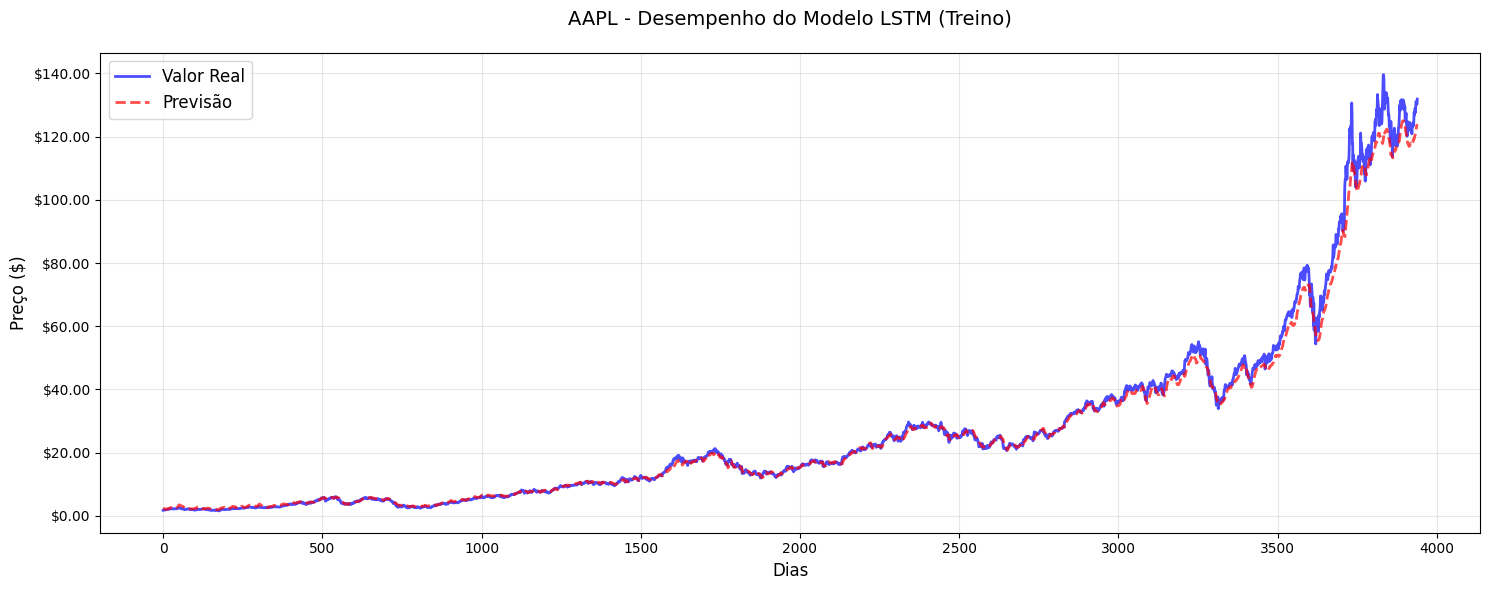


Desempenho no Conjunto de Teste:


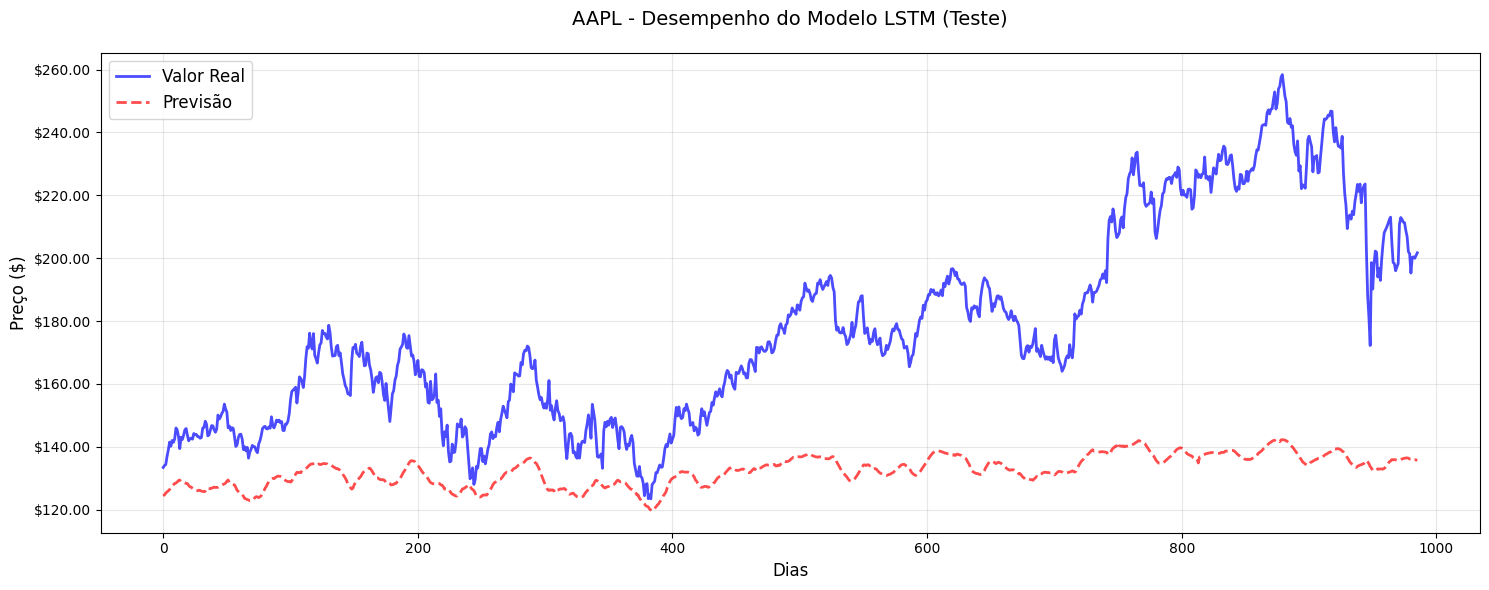


Previsão para os Próximos Dias:


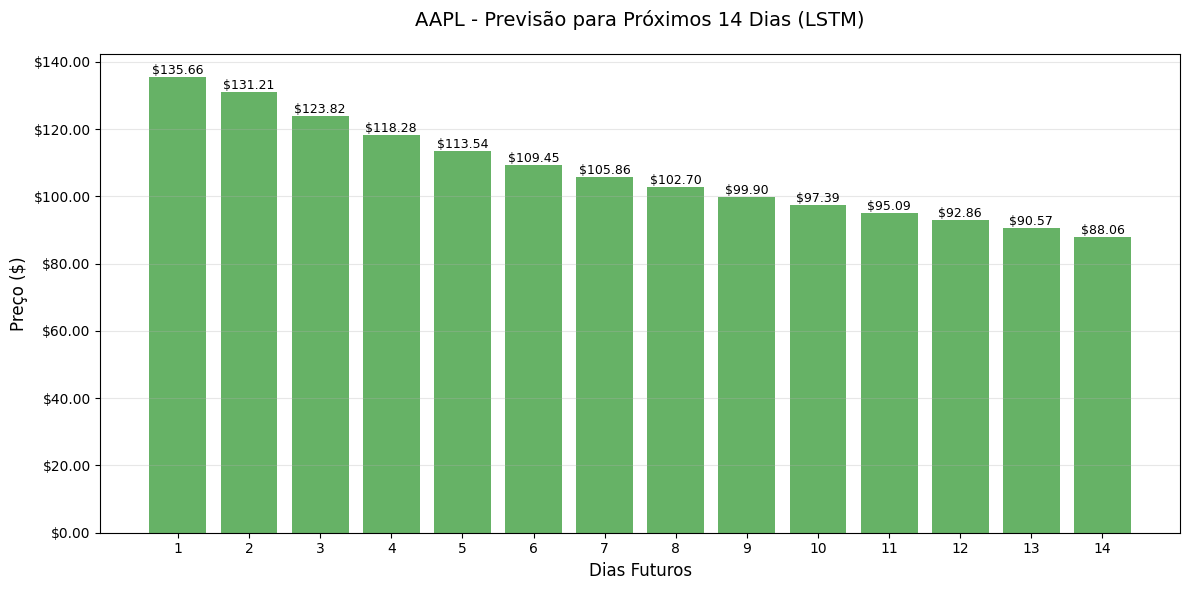


          INICIANDO ANÁLISE PARA AAPL (SimpleRNN)           


/tmp/ipython-input-1-924321266.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period='max', progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]


AAPL: 11221 registros carregados
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

              RESULTADOS PARA AAPL (SimpleRNN)              

Métricas no Conjunto de Treino:
----------------------------------------
MSE:  2.214736
RMSE: 1.488199
MAE:  0.869468
MAPE: 7.09%
----------------------------------------

Métricas no Conjunto de Teste:
----------------------------------------
MSE:  1647.885134
RMSE: 40.594151
MAE:  34.244140
MAPE: 17.80%
----------------------------------------

Desempenho no Conjunto de Treino:


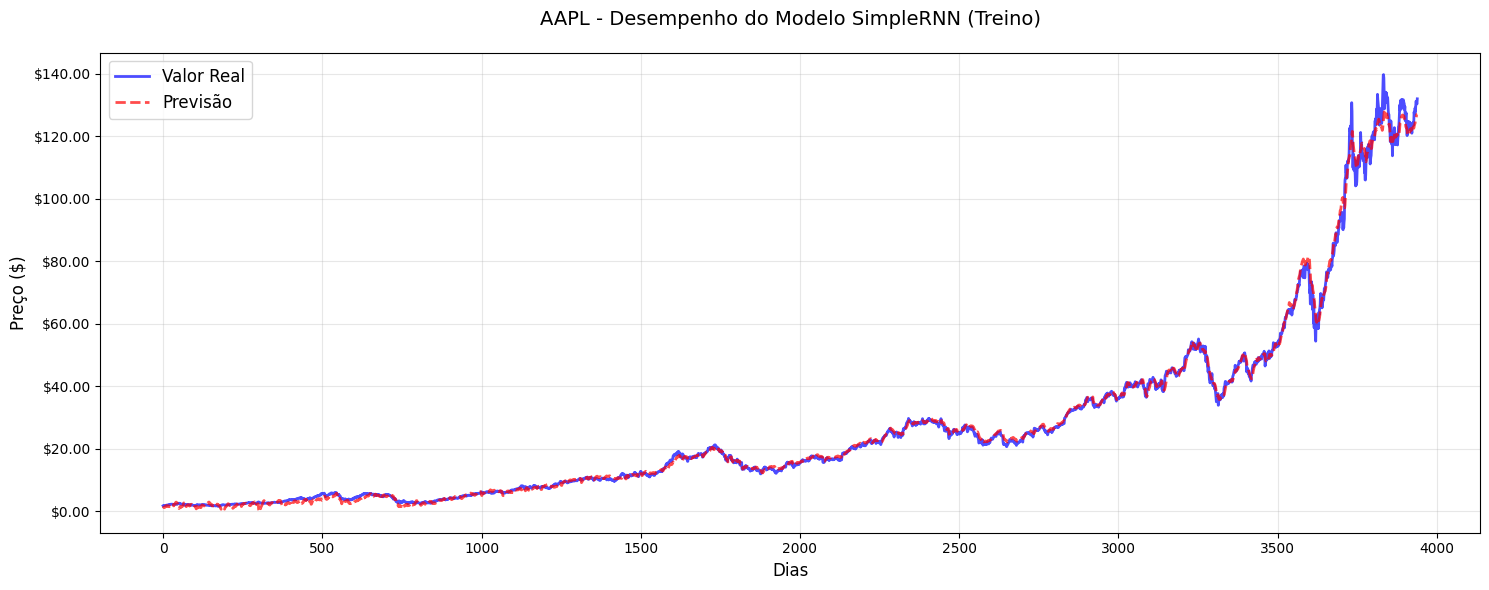


Desempenho no Conjunto de Teste:


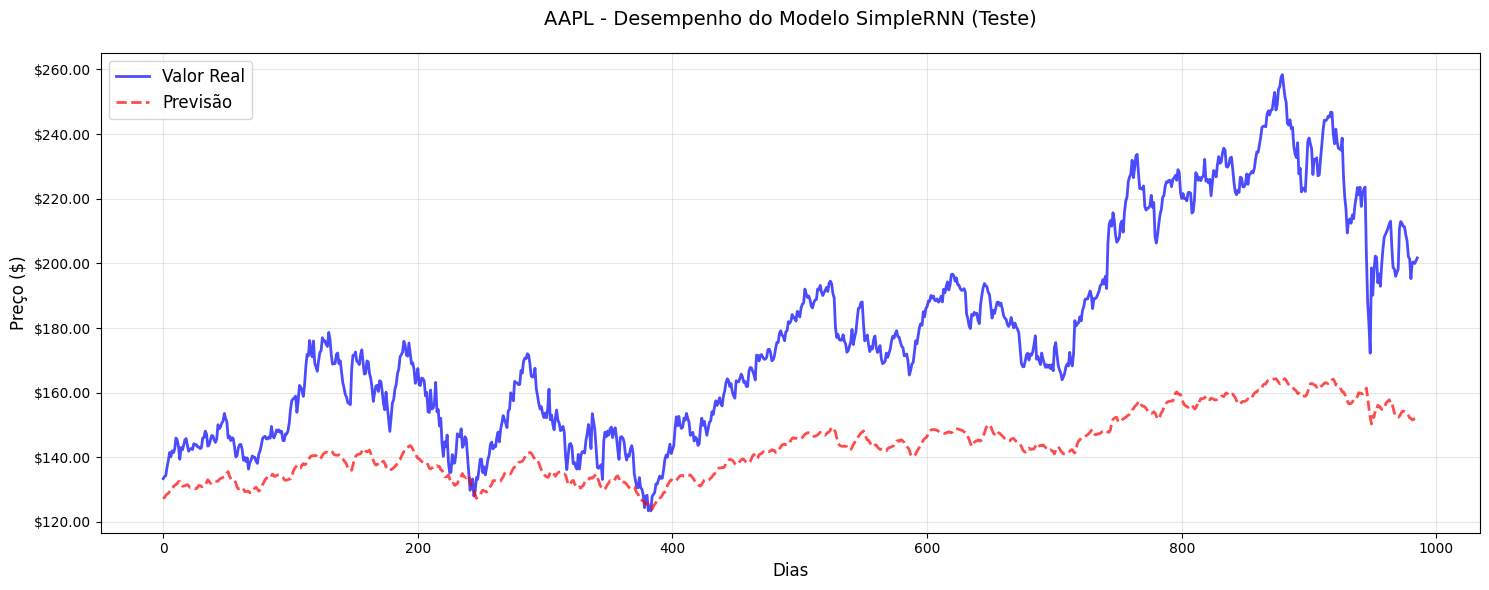


Previsão para os Próximos Dias:


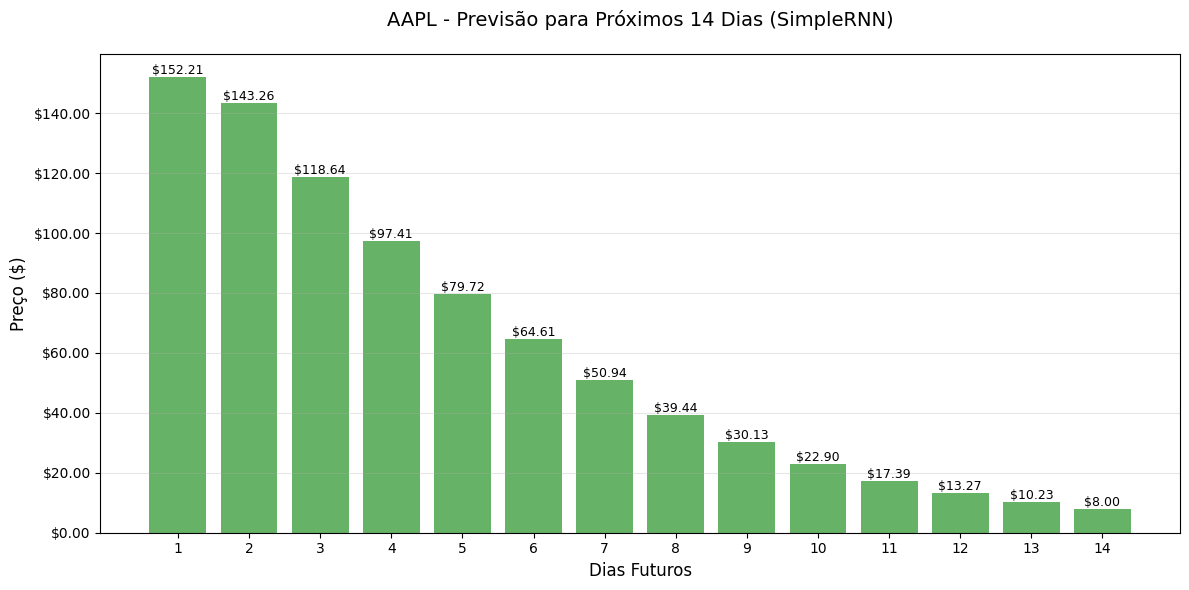


             INICIANDO ANÁLISE PARA AAPL (GRU)              


/tmp/ipython-input-1-924321266.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period='max', progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]


AAPL: 11221 registros carregados
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

                 RESULTADOS PARA AAPL (GRU)                 

Métricas no Conjunto de Treino:
----------------------------------------
MSE:  9.827066
RMSE: 3.134815
MAE:  1.597679
MAPE: 6.86%
----------------------------------------

Métricas no Conjunto de Teste:
----------------------------------------
MSE:  2292.272401
RMSE: 47.877682
MAE:  41.932684
MAPE: 22.17%
----------------------------------------

Desempenho no Conjunto de Treino:


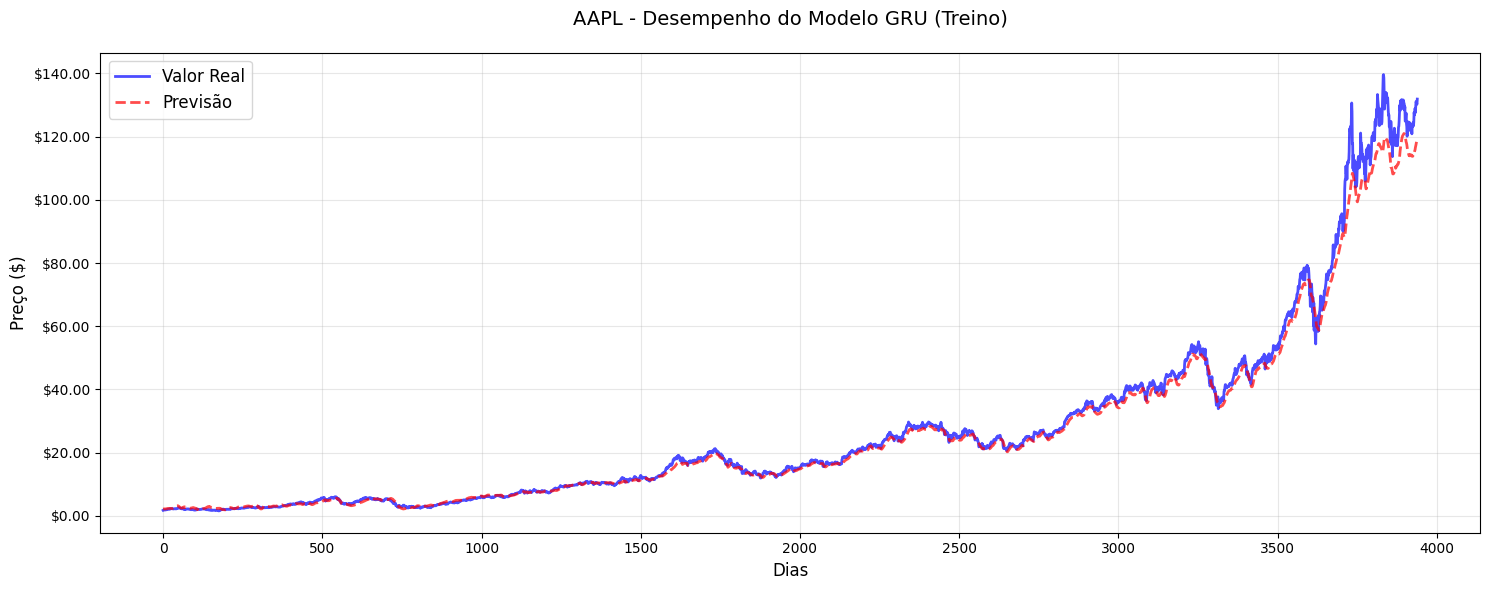


Desempenho no Conjunto de Teste:


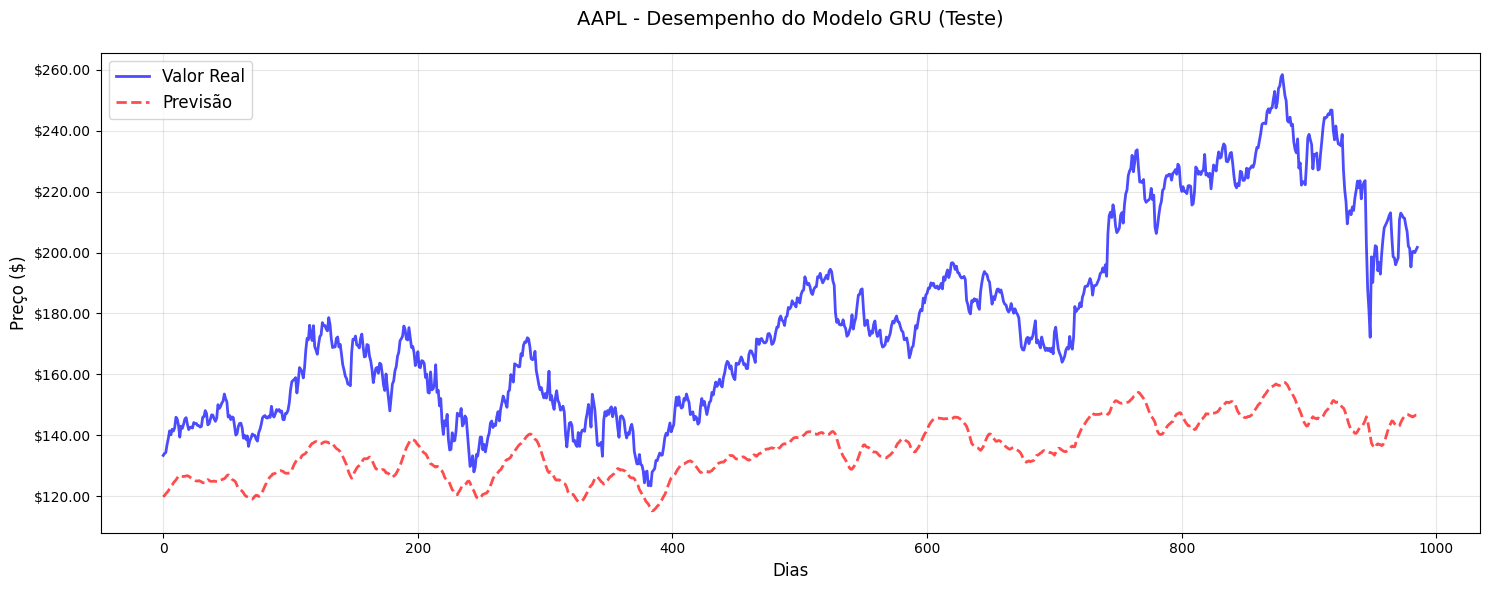


Previsão para os Próximos Dias:


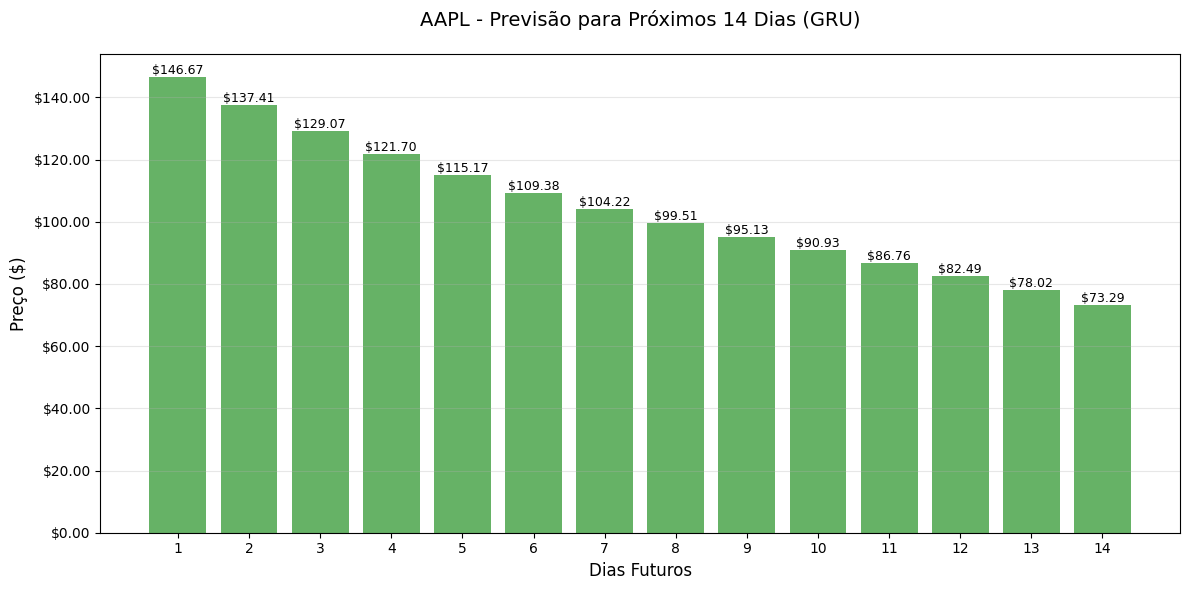


           INICIANDO ANÁLISE PARA BTC-USD (LSTM)            
BTC-USD: 3932 registros carregados


/tmp/ipython-input-1-924321266.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period='max', progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

               RESULTADOS PARA BTC-USD (LSTM)               

Métricas no Conjunto de Treino:
----------------------------------------
MSE:  2865238.524361
RMSE: 1692.701546
MAE:  918.039399
MAPE: 15.16%
----------------------------------------

Métricas no Conjunto de Teste:
----------------------------------------
MSE:  207511382.868551
RMSE: 14405.255391
MAE:  9448.486705
MAPE: 11.88%
----------------------------------------

Desempenho no Conjunto de Treino:


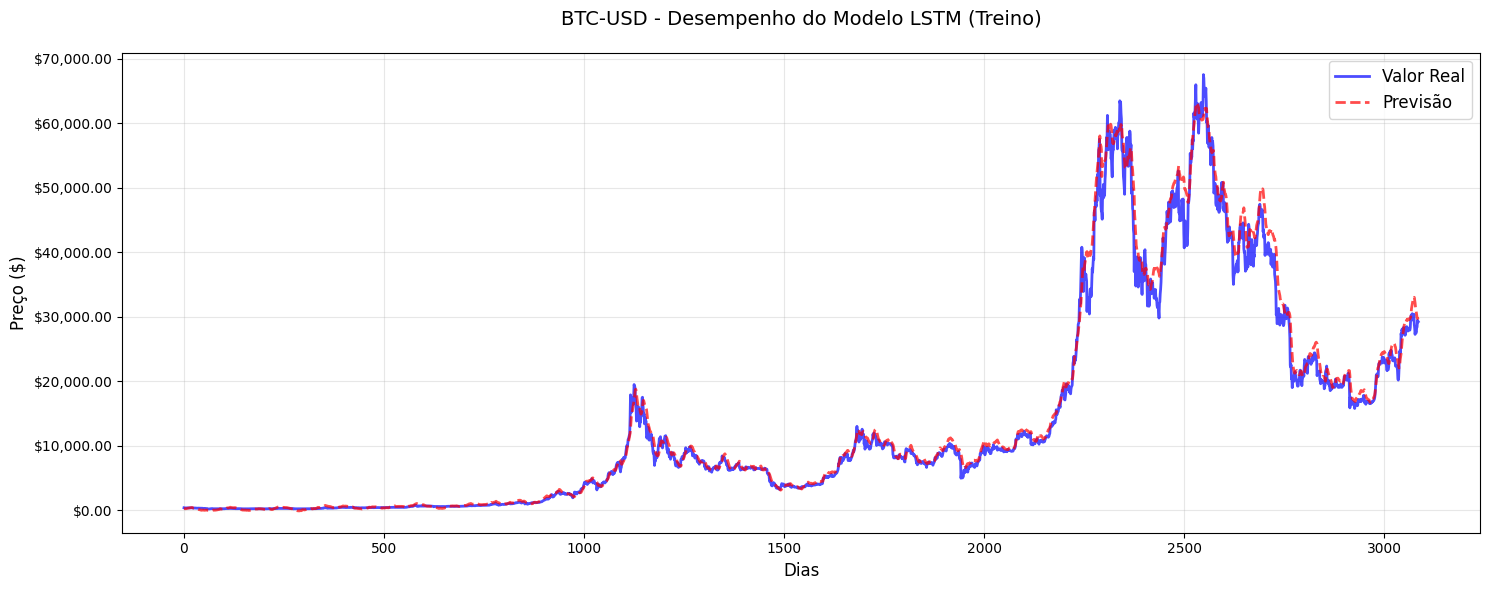


Desempenho no Conjunto de Teste:


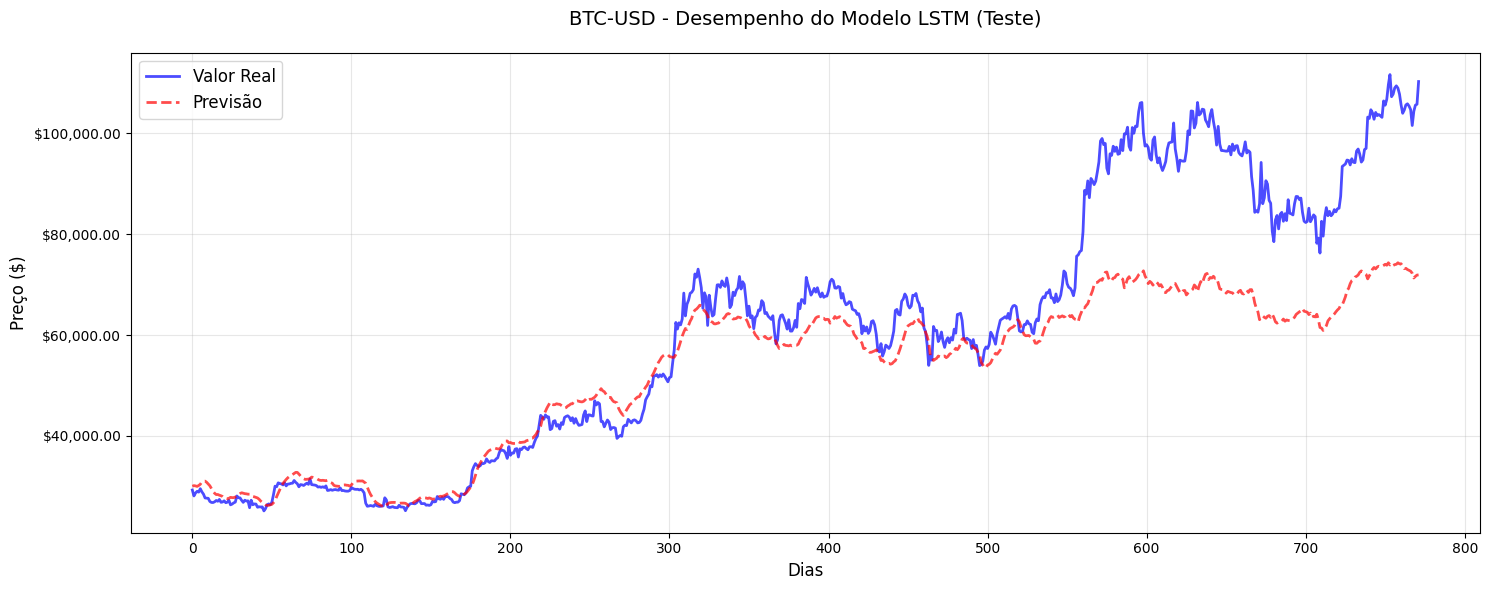


Previsão para os Próximos Dias:


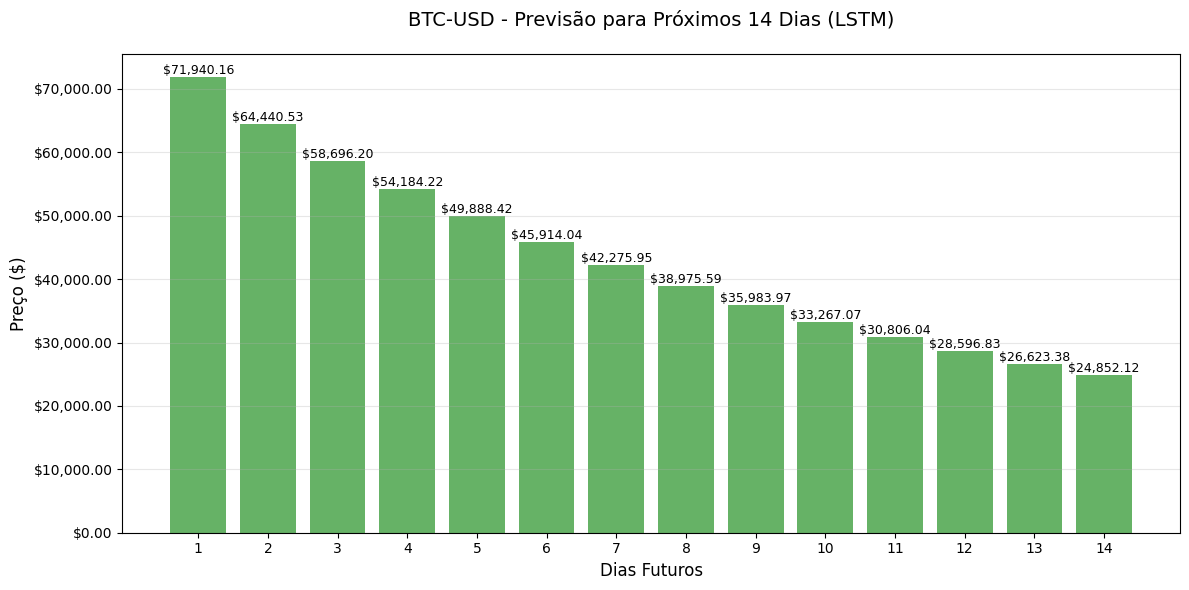


         INICIANDO ANÁLISE PARA BTC-USD (SimpleRNN)         


/tmp/ipython-input-1-924321266.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period='max', progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]


BTC-USD: 3932 registros carregados
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

            RESULTADOS PARA BTC-USD (SimpleRNN)             

Métricas no Conjunto de Treino:
----------------------------------------
MSE:  1997810.668158
RMSE: 1413.439305
MAE:  858.086133
MAPE: 30.40%
----------------------------------------

Métricas no Conjunto de Teste:
----------------------------------------
MSE:  146874709.185809
RMSE: 12119.187645
MAE:  7966.176895
MAPE: 9.77%
----------------------------------------

Desempenho no Conjunto de Treino:


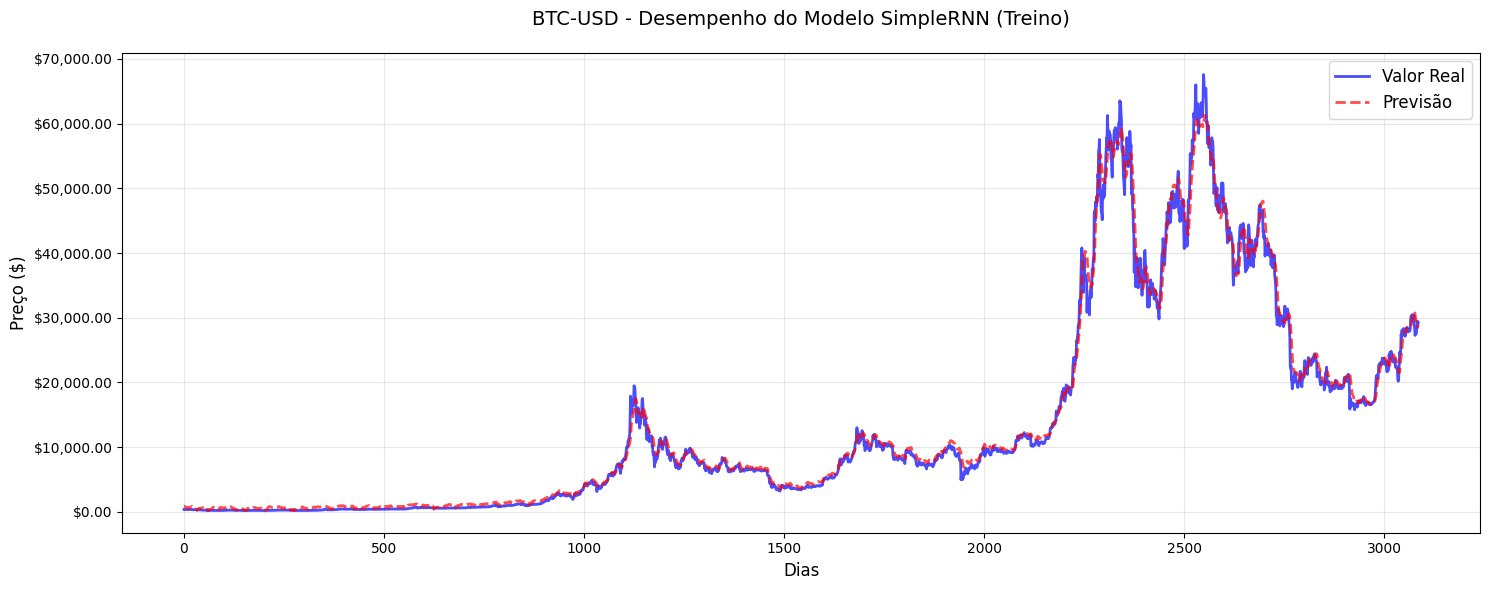


Desempenho no Conjunto de Teste:


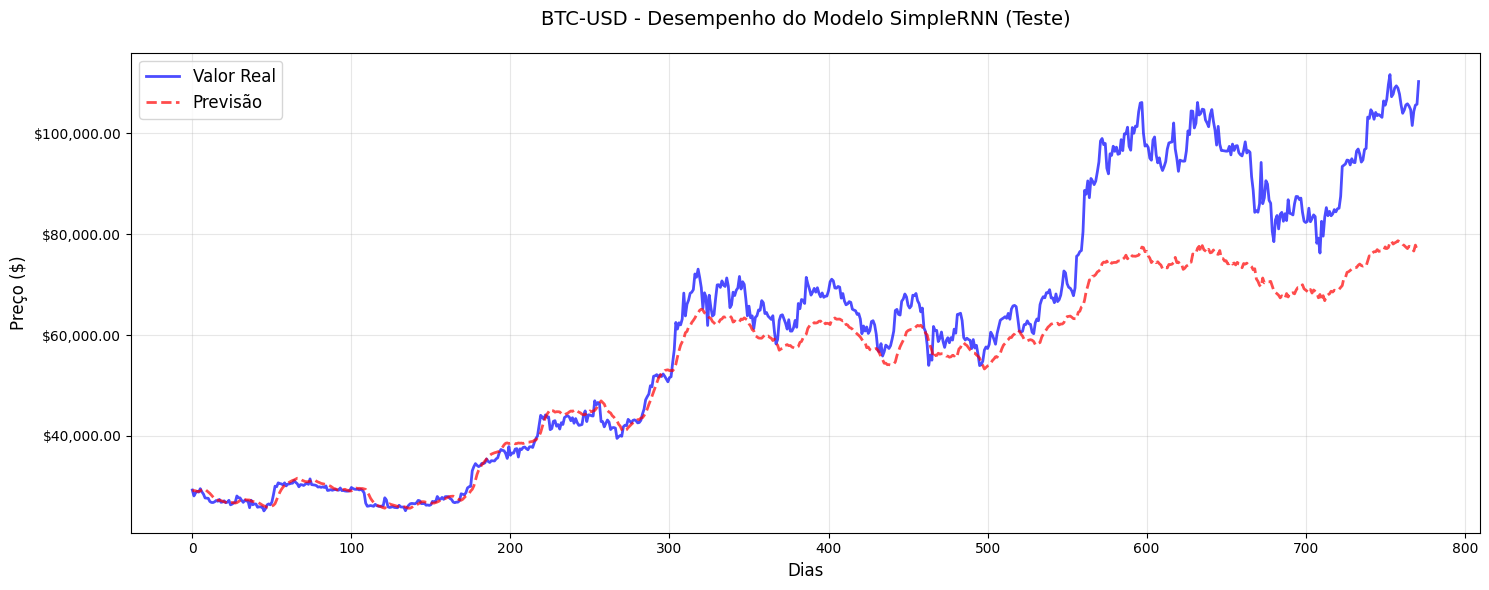


Previsão para os Próximos Dias:


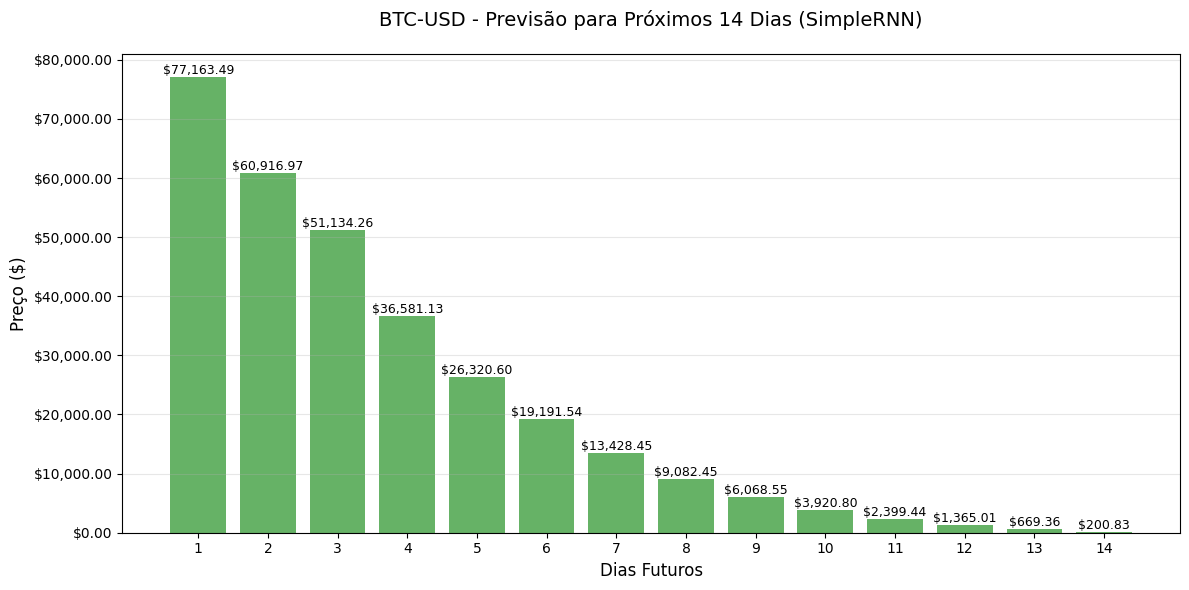


            INICIANDO ANÁLISE PARA BTC-USD (GRU)            
BTC-USD: 3932 registros carregados


/tmp/ipython-input-1-924321266.py:86: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period='max', progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

               RESULTADOS PARA BTC-USD (GRU)                

Métricas no Conjunto de Treino:
----------------------------------------
MSE:  10401549.214809
RMSE: 3225.143286
MAE:  2453.992544
MAPE: 113.10%
----------------------------------------

Métricas no Conjunto de Teste:
----------------------------------------
MSE:  353135298.117037
RMSE: 18791.894479
MAE:  14772.966320
MAPE: 20.63%
----------------------------------------

Desempenho no Conjunto de Treino:


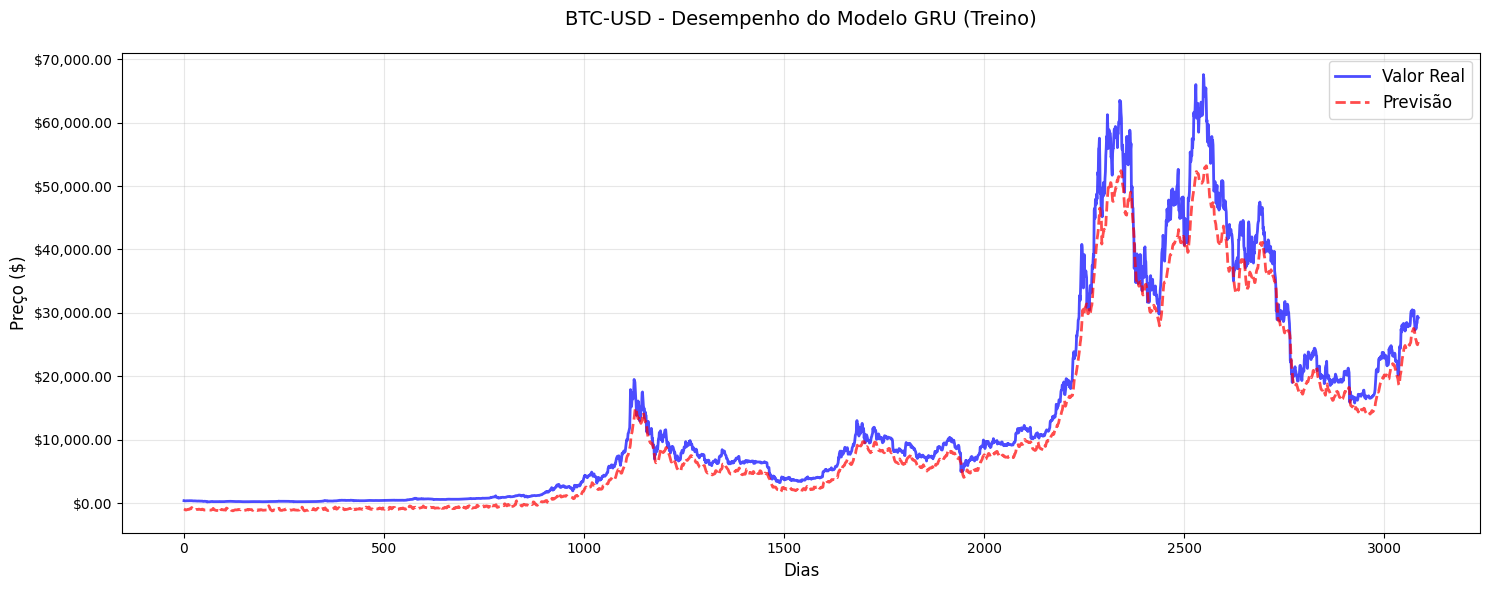


Desempenho no Conjunto de Teste:


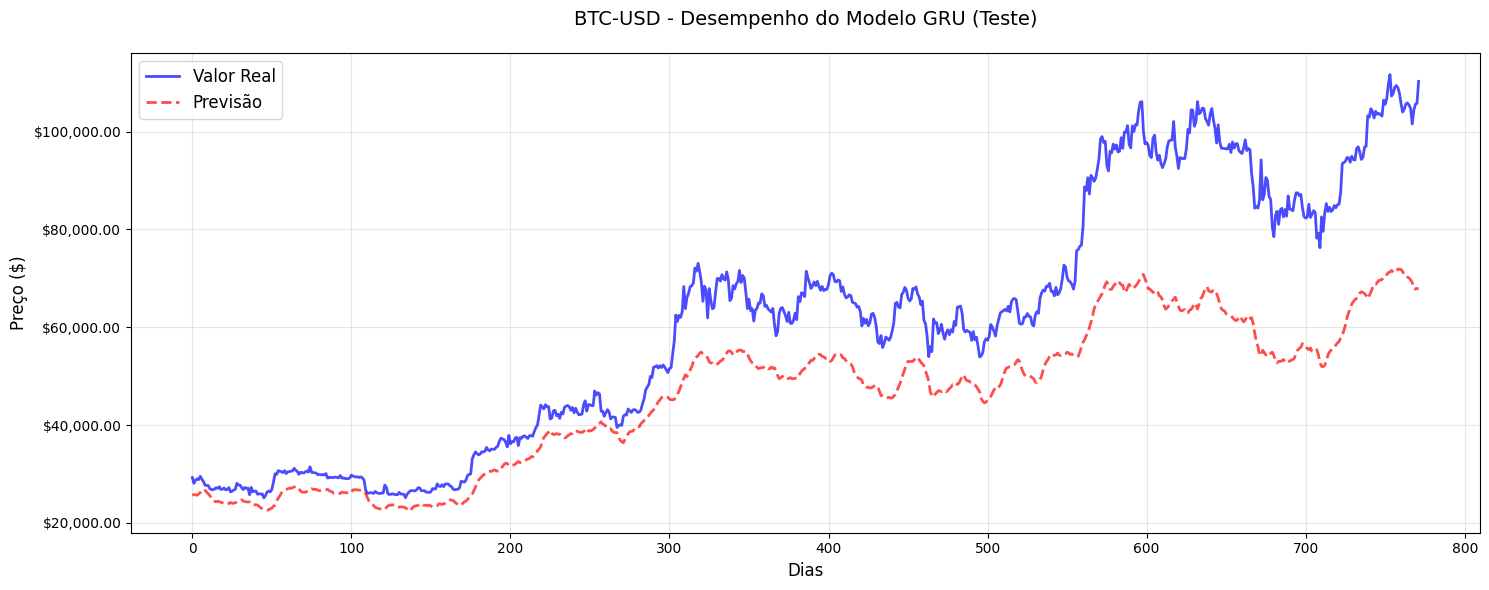


Previsão para os Próximos Dias:


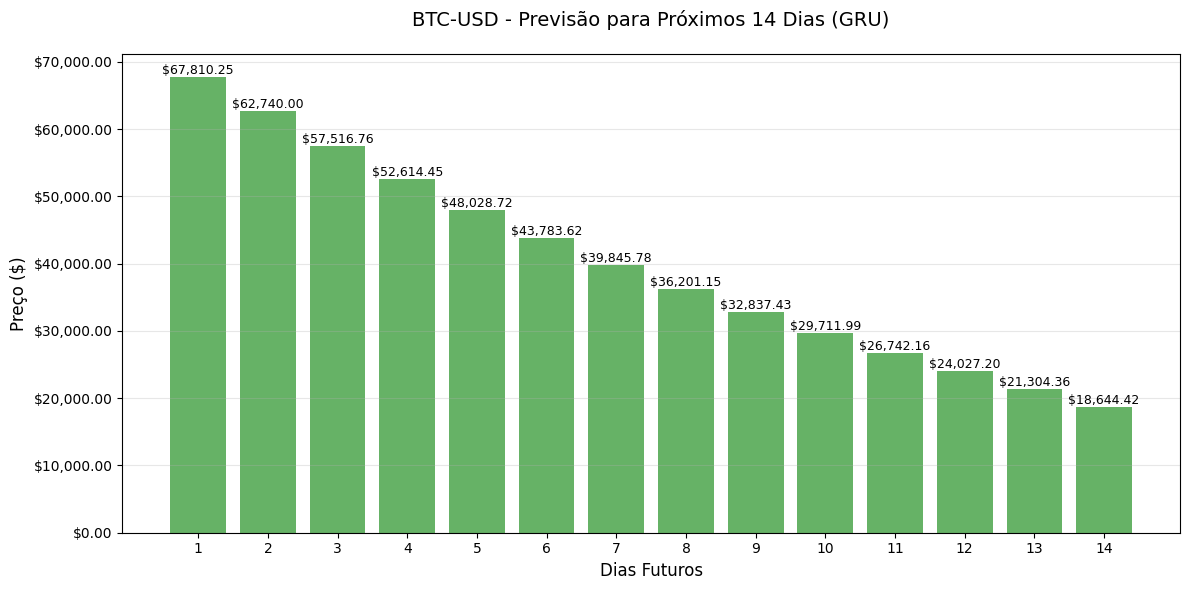

In [1]:
# Instalação dos pacotes necessários
try:
    import yfinance as yf
    import tensorflow as tf
    from tensorflow.keras.layers import Input
    from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
except ImportError:
    !pip install yfinance tensorflow scikit-learn pandas numpy matplotlib tabulate --quiet
    import yfinance as yf
    import tensorflow as tf
    from tensorflow.keras.layers import Input
    from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tabulate import tabulate

# ========= CONFIGURAÇÕES =========
LOOK_BACK = 60
N_REGISTROS = 5000
FORECAST_HORIZON = 14
EPOCHS = 50
BATCH_SIZE = 32
MODEL_TYPES = ['LSTM', 'SimpleRNN', 'GRU']
TICKERS = ['AAPL', 'BTC-USD']

# ========= FUNÇÕES AUXILIARES =========
def format_dollars(x, pos):
    return f'${x:,.2f}'

dollar_formatter = FuncFormatter(format_dollars)

def calculate_metrics(actual, predicted):
    """Calcula várias métricas de avaliação."""
    metrics = {
        'MSE': mean_squared_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'MAPE': mean_absolute_percentage_error(actual, predicted) * 100  # Em porcentagem
    }
    return metrics

def print_metrics(metrics, title):
    """Exibe métricas formatadas."""
    print(f"\n{title}:")
    print("-"*40)
    print(f"MSE:  {metrics['MSE']:.6f}")
    print(f"RMSE: {metrics['RMSE']:.6f}")
    print(f"MAE:  {metrics['MAE']:.6f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    print("-"*40)

def add_technical_indicators(df):
    """Adiciona indicadores técnicos com tratamento robusto."""
    df = df.copy()

    # Médias Móveis
    df['SMA_20'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False, min_periods=1).mean()

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False, min_periods=1).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False, min_periods=1).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False, min_periods=1).mean()

    return df.dropna()

def load_market_data(ticker):
    """Carrega dados do mercado com tratamento de erros."""
    try:
        data = yf.download(ticker, period='max', progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]
        data = data.dropna()
        print(f"{ticker}: {len(data)} registros carregados")
        return data.tail(N_REGISTROS)
    except Exception as e:
        print(f"Falha ao carregar {ticker}: {str(e)}")
        return None

def prepare_training_data(data):
    """Prepara os dados para treinamento com validação."""
    try:
        df = add_technical_indicators(data)
        required_features = ['Open', 'High', 'Low', 'Close', 'Volume',
                           'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'Signal_Line']

        # Verifica se todos os indicadores foram calculados
        missing = [col for col in required_features if col not in df.columns]
        if missing:
            raise ValueError(f"Indicadores faltando: {missing}")

        if len(df) < LOOK_BACK + FORECAST_HORIZON:
            raise ValueError(f"Dados insuficientes. Necessários: {LOOK_BACK+FORECAST_HORIZON}, Disponíveis: {len(df)}")

        # Normalização
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df[required_features])

        # Cria sequências para o modelo
        X, y = [], []
        for i in range(len(scaled) - LOOK_BACK - FORECAST_HORIZON + 1):
            X.append(scaled[i:i+LOOK_BACK])
            y.append(scaled[i+LOOK_BACK:i+LOOK_BACK+FORECAST_HORIZON, 3])  # Close price

        return np.array(X), np.array(y), scaler, required_features
    except Exception as e:
        print(f"Erro na preparação dos dados: {str(e)}")
        return None, None, None, None

def build_model(model_type, input_shape):
    """Constrói modelo com arquitetura correta."""
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Dropout(0.2))

    if model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=False))
    elif model_type == 'SimpleRNN':
        model.add(SimpleRNN(64, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(64, return_sequences=False))

    model.add(Dense(FORECAST_HORIZON))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def plot_predictions(actual, predicted, ticker, model_type, set_name):
    """Visualização profissional dos resultados."""
    plt.figure(figsize=(15, 6))

    # Plot dos dados reais
    plt.plot(actual, 'b-', label='Valor Real', linewidth=2, alpha=0.7)

    # Plot das previsões
    plt.plot(predicted, 'r--', label='Previsão', linewidth=2, alpha=0.7)

    plt.title(f'{ticker} - Desempenho do Modelo {model_type} ({set_name})', fontsize=14, pad=20)
    plt.xlabel('Dias', fontsize=12)
    plt.ylabel('Preço ($)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.gca().yaxis.set_major_formatter(dollar_formatter)
    plt.tight_layout()
    plt.show()

def plot_future_predictions(predictions, ticker, model_type):
    """Visualização das previsões futuras."""
    plt.figure(figsize=(12, 6))
    days = range(1, FORECAST_HORIZON + 1)

    bars = plt.bar(days, predictions, color='green', alpha=0.6)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:,.2f}',
                 ha='center', va='bottom', fontsize=9)

    plt.title(f'{ticker} - Previsão para Próximos {FORECAST_HORIZON} Dias ({model_type})', fontsize=14, pad=20)
    plt.xlabel('Dias Futuros', fontsize=12)
    plt.ylabel('Preço ($)', fontsize=12)
    plt.xticks(days)
    plt.grid(True, axis='y', alpha=0.3)
    plt.gca().yaxis.set_major_formatter(dollar_formatter)
    plt.tight_layout()
    plt.show()

def train_and_evaluate(ticker, model_type):
    """Pipeline completo de treinamento e avaliação."""
    # Carrega e prepara os dados
    data = load_market_data(ticker)
    if data is None:
        return None

    X, y, scaler, feature_names = prepare_training_data(data)
    if X is None:
        return None

    # Divide em treino e teste
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Constroi e treina o modelo
    model = build_model(model_type, (LOOK_BACK, len(feature_names)))
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=0)

    # Avaliação
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Reverte a normalização
    def inverse_transform(data, col_idx=3):
        dummy = np.zeros((data.shape[0], len(feature_names)))
        dummy[:, col_idx] = data[:, 0]  # Pegamos apenas a primeira previsão
        return scaler.inverse_transform(dummy)[:, col_idx]

    # Para visualização, pegamos apenas a primeira previsão de cada sequência
    y_train_actual = inverse_transform(y_train[:, 0:1])
    y_train_pred = inverse_transform(train_pred[:, 0:1])
    y_test_actual = inverse_transform(y_test[:, 0:1])
    y_test_pred = inverse_transform(test_pred[:, 0:1])

    # Cálculo das métricas
    train_metrics = calculate_metrics(y_train_actual, y_train_pred)
    test_metrics = calculate_metrics(y_test_actual, y_test_pred)

    # Visualização
    print(f"\n{'='*60}")
    print(f"RESULTADOS PARA {ticker} ({model_type})".center(60))
    print(f"{'='*60}")

    print_metrics(train_metrics, "Métricas no Conjunto de Treino")
    print_metrics(test_metrics, "Métricas no Conjunto de Teste")

    print("\nDesempenho no Conjunto de Treino:")
    plot_predictions(y_train_actual, y_train_pred, ticker, model_type, "Treino")

    print("\nDesempenho no Conjunto de Teste:")
    plot_predictions(y_test_actual, y_test_pred, ticker, model_type, "Teste")

    # Previsão futura
    last_sequence = X[-1]
    future_prices = []
    current_sequence = last_sequence.copy()

    for _ in range(FORECAST_HORIZON):
        pred = model.predict(current_sequence[np.newaxis, ...], verbose=0)[0]
        future_prices.append(pred[0])  # Pegamos a primeira previsão

        # Atualiza a sequência
        new_row = np.zeros_like(current_sequence[-1])
        new_row[3] = pred[0]  # Atualiza o preço de fechamento
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = new_row

    # Reverte a normalização
    future_prices = np.array(future_prices)
    dummy = np.zeros((len(future_prices), len(feature_names)))
    dummy[:, 3] = future_prices
    future_prices = scaler.inverse_transform(dummy)[:, 3]

    print("\nPrevisão para os Próximos Dias:")
    plot_future_predictions(future_prices, ticker, model_type)

    return model, history

# ========= EXECUÇÃO PRINCIPAL =========
def main():
    print("===== SISTEMA DE PREVISÃO DE PREÇOS =====")
    print("""
    Modelos: LSTM, SimpleRNN e GRU
    Ativos: AAPL (Apple) e BTC-USD (Bitcoin)
    Indicadores: SMA, EMA, RSI, MACD
    Métricas: MSE, RMSE, MAE, MAPE
    """)

    for ticker in TICKERS:
        for model_type in MODEL_TYPES:
            print(f"\n{'='*60}")
            print(f"INICIANDO ANÁLISE PARA {ticker} ({model_type})".center(60))
            print(f"{'='*60}")
            train_and_evaluate(ticker, model_type)

if __name__ == "__main__":
    main()